# Deep Graph Library (DGL) queues model

## Import libraries

In [1]:
import os
import sys
import shutil

os.environ["DGLBACKEND"] = "pytorch"
os.environ["WANDB_NOTEBOOK_NAME"] = "V2.2.1-queues.ipynb"

import dgl
import dgl.nn as dglnn
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import linalg as LA
import wandb
from dgl.data import DGLDataset
from dgl import save_graphs, load_graphs
from dgl.data.utils import makedirs, save_info, load_info, split_dataset
from dgl.dataloading import GraphDataLoader
from torchmetrics.regression import MeanAbsolutePercentageError
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError
from torchmetrics.regression import WeightedMeanAbsolutePercentageError

torch.set_default_dtype(torch.float64)


from datetime import datetime
import networkx as nx
import numpy as np
from datanetAPI import DatanetAPI
import requests
import configparser
import matplotlib.pyplot as plt
from tqdm import tqdm
from ast import literal_eval
import math
import random
from sklearn.preprocessing import normalize

In [2]:
dataset_path = '/data/escenari-slicing/samples-UPC/processed-100-v2.2.1'
save_dataset_path_validation = './V2.2.1-100-queues'
save_dataset_path_train = './V2.2.1-3k'
save_model_path = './V2.2.1-model-100-dataset-inputgraphqueues'
dataset_name_validation="Slicing-V2.2.1-100-queues"
dataset_name_train="Slicing-V2.2.1-3k"

## Dataset reading

In [3]:
class SlicingDataset(DGLDataset):
    """ 
    Parameters
    ----------
    raw_dir : str
        Specifying the directory that will store the
        downloaded data or the directory that
        already stores the input data.
    save_dir : str
        Directory to save the processed dataset.
        Default: the value of `raw_dir`
    force_reload : bool
        Whether to reload the dataset. Default: False
    verbose : bool
        Whether to print out progress information
    """
        
    def __init__(self, 
                 name="default_name", 
                 raw_dir=None, 
                 save_dir=None, 
                 force_reload=False):
        self.tool = DatanetAPI(raw_dir, shuffle=False)
        super(SlicingDataset, self).__init__(
            name=name, 
            raw_dir=raw_dir, 
            save_dir=save_dir, 
            force_reload=force_reload)
        

    def process(self):
        it = iter(self.tool)
        self.graphs = []
        for s in tqdm(it, total=len(self.tool.get_available_files()*79)):
            G = nx.DiGraph(s.get_topology_object().copy())
            R = s.get_routing_matrix()
            T = s.get_traffic_matrix() 
            D = s.get_performance_matrix()
            P = s.get_port_stats()
            S = s.get_slices()
            D_G = nx.DiGraph()

            #AvgBw_sum calculation
            AvgBw_sum = np.zeros((len(G.nodes),len(G.nodes)))
            for src in range(G.number_of_nodes()):
                for dst in range(G.number_of_nodes()):
                    route = R[src,dst]
                    if route:
                        for index, node in enumerate(route):
                            next_node_index = index + 1
                            if next_node_index < len(route):
                                for f_id in range(len(T[src, dst]['Flows'])):
                                    if T[src, dst]['Flows'][f_id]['AvgBw'] != 0 and T[src, dst]['Flows'][f_id]['PktsGen'] != 0:
                                        AvgBw_sum[node][route[next_node_index]] += T[src, dst]['Flows'][f_id]['AvgBw']

            reservations_embb = np.zeros((len(G.nodes),len(G.nodes)))
            reservations_urllc = np.zeros((len(G.nodes),len(G.nodes)))
            reservations_mmtc = np.zeros((len(G.nodes),len(G.nodes)))
            for slice in S:
                for flow in slice["flows"]:
                    route = literal_eval(flow["path"])
                    for index, node in enumerate(route):
                        next_node_index = index + 1
                        if next_node_index < len(route):
                            v_max = float(flow["bandwidth"])*1.20 
                            v_min = float(flow["bandwidth"])*0.80
                            if (slice["type"] == "eMBB"):    
                                reservations_embb[node][route[next_node_index]] += v_min+slice["delta"]*(v_max-v_min)
                            elif (slice["type"] == "URLLC"):
                                reservations_urllc[node][route[next_node_index]] += v_min+slice["delta"]*(v_max-v_min)
                            else:
                                reservations_mmtc[node][route[next_node_index]] += v_min+slice["delta"]*(v_max-v_min)
            for src in range(G.number_of_nodes()):
                for dst in range(G.number_of_nodes()):
                    if src != dst:
                        if G.has_edge(src, dst):
                            
                            D_G.add_node('l_{}_{}'.format(src, dst),
                                capacity=torch.tensor(G.edges[src, dst]['bandwidth']),
                                utilization=torch.tensor(P[src][dst]["utilization"]),
                                avgPacketSize=torch.tensor(P[src][dst]["avgPacketSize"]),
                                offeredTrafficIntensity=torch.tensor(AvgBw_sum[src][dst]/s.get_srcdst_link_bandwidth(src,dst)),
                                nodeType=torch.tensor(0)
                                )
                                    
                        for f_id in range(len(T[src, dst]['Flows'])):
                            if T[src, dst]['Flows'][f_id]['AvgBw'] != 0 and T[src, dst]['Flows'][f_id]['PktsGen'] != 0:
                                D_G.add_node('p_{}_{}_{}'.format(src, dst, f_id),
                                    traffic=torch.tensor(T[src, dst]['Flows'][f_id]['AvgBw']),
                                    packets=torch.tensor(T[src, dst]['Flows'][f_id]['PktsGen']),
                                    delay=torch.tensor(D[src, dst]['Flows'][f_id]['AvgDelay']),
                                    jitter=torch.tensor(D[src, dst]['Flows'][f_id]['Jitter']),
                                    pathLength=torch.tensor(len(R[src,dst])),
                                    drops=torch.tensor(D[src, dst]['AggInfo']['PktsDrop']/T[src, dst]['Flows'][f_id]['PktsGen']),
                                    delta=torch.tensor(slice["delta"]),
                                    nodeType=torch.tensor(1)
                                    )
                                for h_1, h_2 in [R[src, dst][i:i + 2] for i in range(0, len(R[src, dst]) - 1)]:
                                    D_G.add_edge('p_{}_{}_{}'.format(src, dst, f_id), 'l_{}_{}'.format(h_1, h_2), edgeType=torch.tensor(0)) #traverses
                                    D_G.add_edge('l_{}_{}'.format(h_1, h_2), 'p_{}_{}_{}'.format(src, dst, f_id), edgeType=torch.tensor(1)) #composes

                                    for idx, queue in enumerate(P[h_1][h_2]["qosQueuesStats"]):
                                        weight = G.nodes[h_1]['schedulingWeights']
                                        avgDelay = 0
                                        maxDelay = 0
                                        aOTI = 0
                                        #sCT = 0
                                        sliceType = None
                                        sliceNumber = None
                                        calculatedLosses = 0
                                        AvgBwQueue_sum = 0
                                        if weight != "-":
                                            port = G[h_1][h_2]['port']
                                            if (type(weight) != int):
                                                weight = weight.split(";")[port]
                                                if (type(weight) != int):
                                                    weight = weight.split(",")[idx]
                                            if (idx < len(G.nodes[h_1]['tosToQoSqueue'].split(";"))-1): #last is unused  
                                                #Save scheduling weights of the queue
                                                origins = list(map(int,G.nodes[h_1]['tosToQoSqueue'].split(";")[idx].split(",")))

                                                if queue['utilization'] > 0 and float(weight) > 0.001:  
                                                    for slice in S:
                                                        for flow in slice["flows"]:
                                                            if int(flow["origin_node"]) in origins:
                                                                sliceType = slice["type"]
                                                                sliceNumber = slice["number"]
                                                                AvgBwQueue_sum += T[int(flow['origin_node']), int(flow['destination'])]['Flows'][0]['AvgBw']
                                                        if sliceType is not None:
                                                            break
                                                        else:
                                                            AvgBwQueue_sum = 0
                                            
                                            trafficPortion = float(s.get_srcdst_link_bandwidth(h_1,h_2))*(float(weight)/100)
                                            aOTI = AvgBwQueue_sum/trafficPortion

                                            maxDelay = 31*queue['avgPacketSize']/trafficPortion
                                            if aOTI >= 1:
                                                avgDelay = maxDelay
                                            else: #aOTI < 1
                                                avgDelay = min(queue['avgPacketSize']/trafficPortion*(1/(1-aOTI)),maxDelay)
                                            if aOTI <= 1:
                                                calculatedLosses = 0
                                            else: # aOTI > 1
                                                calculatedLosses = (AvgBwQueue_sum-trafficPortion)/AvgBwQueue_sum
                                        else:
                                            weight = 100
                                        if s.get_srcdst_link_bandwidth(h_1,h_2) > 0 and maxDelay > 0:
                                            D_G.add_node('q_{}_{}_{}'.format(h_1, h_2, idx),
                                                weight=torch.tensor(float(weight)),
                                                utilization=torch.tensor(queue['utilization']),
                                                #aOTI=torch.tensor(aOTI),
                                                calculatedLosses=torch.tensor(calculatedLosses),
                                                maxDelay=torch.tensor(maxDelay),
                                                nodeType=torch.tensor(2)
                                                )
                                            if sliceType is not None:
                                                D_G.add_edge('p_{}_{}_{}'.format(src, dst, f_id), 'q_{}_{}_{}'.format(h_1, h_2, idx), edgeType=torch.tensor(2)) #uses
                                                D_G.add_edge('q_{}_{}_{}'.format(h_1, h_2, idx), 'p_{}_{}_{}'.format(src, dst, f_id), edgeType=torch.tensor(3)) #serves
                                                D_G.add_edge('l_{}_{}'.format(h_1, h_2), 'q_{}_{}_{}'.format(h_1, h_2, idx), edgeType=torch.tensor(4)) #hosts
                                                D_G.add_edge('q_{}_{}_{}'.format(h_1, h_2, idx), 'l_{}_{}'.format(h_1, h_2), edgeType=torch.tensor(5)) #resides
                                            
            D_G.remove_nodes_from([node for node, in_degree in D_G.in_degree() if in_degree == 0])
            D_G.remove_nodes_from([node for node, out_degree in D_G.out_degree() if out_degree == 0])

            g = dgl.from_networkx(D_G, node_attrs=["nodeType"])

            nodeTypes = nx.get_node_attributes(D_G, 'nodeType')
            nodes = D_G.nodes
            g.ndata[dgl.NTYPE] = torch.stack([nodeTypes[e] for e in nodes])
            g.ndata[dgl.NID] = torch.tensor([*range(0,len(D_G.nodes))])

            edgeTypes = nx.get_edge_attributes(D_G, 'edgeType')
            edges = D_G.edges
            g.edata[dgl.ETYPE] = torch.stack([edgeTypes[e] for e in edges])
            g.edata[dgl.EID] = torch.tensor([*range(0,len(D_G.edges))])
            g = dgl.to_heterogeneous(g, ['link','path','queue'], ['traverses','composes', 'uses', 'serves', 'hosts', 'resides'])

            capacities, utilizations, avgPacketSizes, offeredTrafficIntensities, nodeTypesLink = ([] for i in range(5))
            
            traffics, packets, delays, jitters, pathLengths, drops, deltas, nodeTypesPath = ([] for i in range(8))

            weights, queueUtilizations, calculatedLosses, maxDelays, nodeTypesQueue  = ([] for i in range(5))
            
            for node in D_G.nodes(data=True):
                if node[1]["nodeType"] == 0: #LINK               
                    capacities.append(node[1]["capacity"])
                    utilizations.append(node[1]["utilization"])
                    avgPacketSizes.append(node[1]["avgPacketSize"])
                    offeredTrafficIntensities.append(node[1]["offeredTrafficIntensity"])
                    nodeTypesLink.append(node[1]["nodeType"])
                    
                elif node[1]["nodeType"] == 1: #FLOW/PATH
                    traffics.append(node[1]["traffic"])
                    packets.append(node[1]["packets"])
                    delays.append(node[1]["delay"]) #TO PREDICT
                    jitters.append(node[1]["jitter"]) #TO PREDICT
                    drops.append(node[1]["drops"]) #TO PREDICT    
                    pathLengths.append(node[1]["pathLength"])
                    deltas.append(node[1]["delta"])
                    nodeTypesPath.append(node[1]["nodeType"])
                    
                else : #if node[1]["nodeType"] == 2: #QUEUE
                    weights.append(node[1]["weight"])
                    queueUtilizations.append(node[1]["utilization"])
                    calculatedLosses.append(node[1]["calculatedLosses"])
                    maxDelays.append(node[1]["maxDelay"])
                    nodeTypesQueue.append(node[1]["nodeType"])

            #create tensors
            g.nodes["link"].data["capacity"] = torch.stack(capacities)
            g.nodes["link"].data["utilization"] = torch.stack(utilizations)
            g.nodes["link"].data["avgPacketSize"] = torch.stack(avgPacketSizes)
            g.nodes["link"].data["offeredTrafficIntensity"] = torch.stack(offeredTrafficIntensities)
            g.nodes["link"].data["nodeType"] = torch.stack(nodeTypesLink)
            
            g.nodes["path"].data["traffic"] = torch.stack(traffics)
            g.nodes["path"].data["packets"] = torch.stack(packets)
            g.nodes["path"].data["delay"] = torch.stack(delays)
            g.nodes["path"].data["jitter"] = torch.stack(jitters)
            g.nodes["path"].data["drops"] = torch.stack(drops)
            g.nodes["path"].data["pathLength"] = torch.stack(pathLengths)
            g.nodes["path"].data["delta"] = torch.stack(deltas)
            g.nodes["path"].data["nodeType"] = torch.stack(nodeTypesPath)

            g.nodes["queue"].data["weight"] = torch.stack(weights)
            g.nodes["queue"].data["queueUtilization"] = torch.stack(queueUtilizations)
            g.nodes["queue"].data["calculatedLosses"] = torch.stack(calculatedLosses)
            g.nodes["queue"].data["maxDelay"] = torch.stack(maxDelays)
            g.nodes["queue"].data["nodeType"] = torch.stack(nodeTypesQueue)

            self.graphs.append(g)
        self.save()
        
    def getGraphs(self):
        return self.graphs

    
    def __getitem__(self, idx):
        """ Get graph and label by index
        Parameters
        ----------
        idx : int
            Item index

        Returns
        -------
        (dgl.DGLGraph)
        """
        return self.graphs[idx]

    def __len__(self):
        """Number of graphs in the dataset"""
        return 3492#len(self.graphs) #3492

    def collate_fn(self, batch):
        # batch is a list of tuple (graph, label)
        graphs = [e[0] for e in batch]
        g = dgl.batch(graphs)
        labels = [e[1] for e in batch]
        labels = torch.stack(labels, 0)
        return g

    def save(self):
        # save graphs and labels
        graph_path = os.path.join(self.save_dir, 'dgl_graph.bin')
        save_graphs(graph_path, self.graphs)
        
    def load(self):
        # load processed data from directory `self.save_path`
        graph_path = os.path.join(self.save_dir, 'dgl_graph.bin')
        self.graphs = load_graphs(graph_path)


    def has_cache(self):
        # check whether there is processed data in `self.save_path`
        graph_path = os.path.join(self.save_dir, 'dgl_graph.bin')
        return os.path.exists(graph_path)

1. Obtenir graph base dirigit de cada sample  
2. Afegir atributs desitjats al graf
3. Carregar-lo a GPU

## Dataloader initialization

In [4]:
# define dataset
ds_train = SlicingDataset(
    name=dataset_name_train,
    raw_dir=dataset_path, 
    save_dir=save_dataset_path_train, 
    force_reload=False)

ds_train.load()

In [5]:
ds_validation = SlicingDataset(
    name=dataset_name_validation,
    raw_dir=dataset_path, 
    save_dir=save_dataset_path_validation, 
    force_reload=False)

ds_validation.load()

## Dataset split

In [6]:
#ds_train, ds_validation, ds_test = split_dataset(dataset,[0.9,0.01,0.09])

In [7]:
#print(dataset)

In [8]:
#print length of the datasets
# print(len(ds_train))
# print(len(ds_validation))
# print(len(ds_test))

## GNN model

In [9]:
# Define a Heterograph Conv model

class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        aggregation_function = 'sum'
        self.conv1 = dglnn.HeteroGraphConv({
            'traverses': dglnn.GraphConv(in_feats, hid_feats),
            'composes': dglnn.GraphConv(in_feats, hid_feats),
            'uses': dglnn.GraphConv(in_feats, hid_feats),
            'serves': dglnn.GraphConv(in_feats, hid_feats),
            'hosts': dglnn.GraphConv(in_feats, hid_feats),
            'resides': dglnn.GraphConv(in_feats, hid_feats)
            },
            aggregate=aggregation_function)
        self.conv2 = dglnn.HeteroGraphConv({
            'traverses': dglnn.GraphConv(hid_feats, out_feats),
            'composes': dglnn.GraphConv(hid_feats, out_feats),
            'uses': dglnn.GraphConv(hid_feats, out_feats),
            'serves': dglnn.GraphConv(hid_feats, out_feats),
            'hosts': dglnn.GraphConv(hid_feats, out_feats),
            'resides': dglnn.GraphConv(hid_feats, out_feats)
            },
            aggregate=aggregation_function)
  
    def forward(self, graph, inputs):
        # inputs are features of the nodes
        
        #print(inputs)
        h = self.conv1(graph, inputs)
        h = {k: torch.nn.functional.leaky_relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        h = {k: torch.nn.functional.sigmoid(v) for k, v in h.items()}
        return h

In [10]:
model = RGCN(4,20,3)
model.to(torch.double)

RGCN(
  (conv1): HeteroGraphConv(
    (mods): ModuleDict(
      (traverses): GraphConv(in=4, out=20, normalization=both, activation=None)
      (composes): GraphConv(in=4, out=20, normalization=both, activation=None)
      (uses): GraphConv(in=4, out=20, normalization=both, activation=None)
      (serves): GraphConv(in=4, out=20, normalization=both, activation=None)
      (hosts): GraphConv(in=4, out=20, normalization=both, activation=None)
      (resides): GraphConv(in=4, out=20, normalization=both, activation=None)
    )
  )
  (conv2): HeteroGraphConv(
    (mods): ModuleDict(
      (traverses): GraphConv(in=20, out=3, normalization=both, activation=None)
      (composes): GraphConv(in=20, out=3, normalization=both, activation=None)
      (uses): GraphConv(in=20, out=3, normalization=both, activation=None)
      (serves): GraphConv(in=20, out=3, normalization=both, activation=None)
      (hosts): GraphConv(in=20, out=3, normalization=both, activation=None)
      (resides): GraphConv(i

In [11]:
def joinFeatures(fs):
    features = []
    for feature in fs:
        if feature == "_ID" or feature == "nodeType" or feature == "delay" or feature == "drops" or feature == "jitter":
            continue
        else:
            features.append(fs[feature])
    return features

In [12]:
def transformFeatures(g):
    features = ["delay", "drops", "jitter", 
                "capacity", "utilization", "avgPacketSize", "offeredTrafficIntensity", 
                "traffic", "packets", "pathLength", "delta",
                "weight", "queueUtilization", "queueLosses", "queueDelay"]
    for feature in features:
        #transformation of output features
        if feature == "delay":
            g.nodes['path'].data['delay'] = torch.clamp(g.nodes['path'].data['delay'], max=0.0230716) #IQR 90
            g.nodes['path'].data['delay'] = (g.nodes['path'].data['delay']-0.00001)/(0.0230716-0.00001)            
            
        elif feature == "drops":
            #continue
            g.nodes['path'].data['drops'] = torch.clamp(g.nodes['path'].data['drops'], max=0.741) #IQR 90
            g.nodes['path'].data['drops'] = (g.nodes['path'].data['drops']/0.741)
            
        elif feature == "jitter":
            g.nodes['path'].data['jitter'] = torch.clamp(g.nodes['path'].data['jitter'], max=0.000022) #IQR
            g.nodes['path'].data['jitter'] = (g.nodes['path'].data['jitter'])/(0.000022)

        
        #transformation of input link features
        elif feature == "capacity":
            g.nodes['link'].data['capacity'] = (g.nodes['link'].data['capacity']-25000000)/(450000000-25000000)
            
        elif feature == "utilization":
            g.nodes['link'].data['utilization'] = (g.nodes['link'].data['utilization']-0)/(1-0)
            
        elif feature == "avgPacketSize":
            g.nodes['link'].data['avgPacketSize'] = torch.clamp(g.nodes['link'].data['avgPacketSize'], min=0) #some negative values found in the small dataset
            g.nodes['link'].data['avgPacketSize'] = (g.nodes['link'].data['avgPacketSize']-0)/(15500.53-0)
            
        elif feature == "offeredTrafficIntensity":
            g.nodes['link'].data['offeredTrafficIntensity'] = (g.nodes['link'].data['offeredTrafficIntensity']-0)/(4.59-0)

        
        #transformation of input path features
        elif feature == "traffic":
            g.nodes['path'].data['traffic'] = (g.nodes['path'].data['traffic']-249526)/(22531500-249526)
            
        elif feature == "packets":
            g.nodes['path'].data['packets'] = (g.nodes['path'].data['packets']-623.86)/(3772.93-623.86)
            
        elif feature == "pathLength":
            g.nodes['path'].data['pathLength'] = (g.nodes['path'].data['pathLength']-4)/(14-4)
            
        elif feature == "delta":
            g.nodes['path'].data['delta'] = (g.nodes['path'].data['delta']-0.001)/(0.998-0.001)

        
        #transformation of input queue features
        elif feature == "weight":
            g.nodes['queue'].data['weight'] = (g.nodes['queue'].data['weight']-0)/(100-0)
            
        elif feature == "queueUtilization":
            g.nodes['queue'].data['queueUtilization'] = (g.nodes['queue'].data['queueUtilization']-0.00001)/(1.00006-0.00001)
            
        elif feature == "calculatedLosses":
            continue
            
        elif feature == "maxDelay":
            g.nodes['queue'].data['maxDelay'] = torch.clamp(g.nodes['queue'].data['maxDelay'], max=4.96) #IQR
            g.nodes['queue'].data['maxDelay'] = (g.nodes['queue'].data['maxDelay']-0.00003)/(4.96-0.00003)
    
    return g

## Training

In [13]:
def calculate_smape(actual, predicted):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE)
    
    :param actual: list of actual values
    :param predicted: list of predicted values
    :return: SMAPE as a percentage
    """
    # Ensure actual and predicted lists have the same length
    if len(actual) != len(predicted):
        raise ValueError("Input lists must have the same length")
    
    # Calculate SMAPE
    n = len(actual)
    total_error = 0
    for a, p in zip(actual, predicted):
        if p == 0 and a == 0:
            continue
        else:
            total_error += 2 * (abs(a - p) / (abs(a) + abs(p)))
    
    smape = (total_error / n)
    return smape

In [14]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_object = nn.L1Loss() #MAE

metric = nn.L1Loss()

loss_values = []
val_values_delay = []
val_values_not_loss = []
val_values_jitter = []

batch_size = 20
early_stopping_window = 20

In [15]:
for g in ds_train[0]:
    g = transformFeatures(g)
for g in ds_validation[0]:
    g = transformFeatures(g)
for g in ds_test.dataset[0]:
    g = transformFeatures(g)

In [16]:
not_improved_epochs = 0
best_loss_delay = None
best_loss_not_loss = None

torch.set_printoptions(sci_mode=False)

for epoch in range(10000):
    if not_improved_epochs > early_stopping_window: #finished learning
        break
    batch = random.sample(ds_train[0], batch_size)
    for g in batch:
        #g = transformFeatures(g)
        
        link_feats = torch.transpose(torch.stack(joinFeatures(g.nodes['link'].data)),0,1).contiguous()
        path_feats = torch.transpose(torch.stack(joinFeatures(g.nodes['path'].data)),0,1).contiguous()
        queue_feats = torch.transpose(torch.stack(joinFeatures(g.nodes['queue'].data)),0,1).contiguous()

        labels = torch.stack((g.nodes['path'].data['delay'], g.nodes['path'].data['drops'], g.nodes['path'].data['jitter'] ))
        #print(labels)
        
        node_features = {'link': link_feats, 'path': path_feats, 'queue': queue_feats}

        model.train()
        
        # forward propagation by using all nodes and extracting the path embeddings
        logits = model(g, node_features)['path']
        logits = torch.transpose(logits,0,1)
        
        # compute loss
        loss = loss_object(logits, labels)
        loss_values.append(loss.item())
        
        # backward propagation
        opt.zero_grad()
        loss.backward()
        opt.step()
    #validate model
    val_values_epoch_delay = []
    val_values_epoch_not_loss = []
    val_values_epoch_jitter = []
    
    with torch.no_grad():
        for g in ds_validation[0]:

            #g = transformFeatures(g)
            
            link_feats = torch.transpose(torch.stack(joinFeatures(g.nodes['link'].data)),0,1)
            path_feats = torch.transpose(torch.stack(joinFeatures(g.nodes['path'].data)),0,1)
            queue_feats = torch.transpose(torch.stack(joinFeatures(g.nodes['queue'].data)),0,1)
            labels = torch.stack((g.nodes['path'].data['delay'], g.nodes['path'].data['drops'], g.nodes['path'].data['jitter'] ))
            node_features = {'link': link_feats, 'path': path_feats, 'queue': queue_feats}
            
            logits = model(g, node_features)['path']
            logits = torch.transpose(logits,0,1)
            
            val_loss_delay = calculate_smape(((logits[0]+2)*(0.0230716-0.00001))+0.00001, ((labels[0]+2)*(0.0230716-0.00001))+0.00001)*100 #denormalization
            val_loss_not_loss = calculate_smape(((2+logits[1])*0.741), ((2+labels[1])*0.741))*100
            val_loss_jitter = calculate_smape((logits[2]+2)*0.000022, (labels[2]+2)*0.000022)*100
            
            val_values_delay.append(val_loss_delay.item())
            val_values_not_loss.append(val_loss_not_loss.item())
            val_values_jitter.append(val_loss_jitter.item())
            
            val_values_epoch_delay.append(val_loss_delay.item())
            val_values_epoch_not_loss.append(val_loss_not_loss.item())
            val_values_epoch_jitter.append(val_loss_jitter.item())
    
    val_epoch_delay = float(sum(val_values_epoch_delay)/len(val_values_epoch_delay))
    val_epoch_not_loss = float(sum(val_values_epoch_not_loss)/len(val_values_epoch_not_loss))
    val_epoch_jitter = float(sum(val_values_epoch_jitter)/len(val_values_epoch_jitter))

                                                                  
    if best_loss_delay is None or (val_epoch_delay < best_loss_delay and val_epoch_not_loss < best_loss_not_loss): #and val_epoch_jitter < best_loss_jitter): #only save best model
        best_loss_delay = val_epoch_delay
        best_loss_not_loss = val_epoch_not_loss
        best_loss_jitter = val_epoch_jitter
        
        not_improved_epochs = 0
        torch.save(model.state_dict(), save_model_path)
    else:
        not_improved_epochs += 1
        
    #if epoch%10 == 0:
    print(f"Epoch: {epoch}, train loss: {loss}, validation smape delay: {val_epoch_delay}, validation smape losses: {val_epoch_not_loss}, validation smape jitter: {val_epoch_jitter}")

Epoch: 0, train loss: 0.41853991677808206, validation smape delay: 17.58084428893722, validation smape losses: 21.391049188194494, validation smape jitter: 26.63582829018647
Epoch: 1, train loss: 0.28632291934084086, validation smape delay: 17.377174630679292, validation smape losses: 29.465317306482376, validation smape jitter: 20.070111941891003
Epoch: 2, train loss: 0.2945544617502072, validation smape delay: 13.512394129624905, validation smape losses: 21.194951840053385, validation smape jitter: 28.395396081929846
Epoch: 3, train loss: 0.4957668650844689, validation smape delay: 16.868684118130503, validation smape losses: 28.057634100024295, validation smape jitter: 14.67827839307923
Epoch: 4, train loss: 0.23638097713938117, validation smape delay: 17.94890578646472, validation smape losses: 17.208627883110346, validation smape jitter: 24.577378977879853
Epoch: 5, train loss: 0.2521165248438573, validation smape delay: 16.81666083444888, validation smape losses: 20.9149010514660

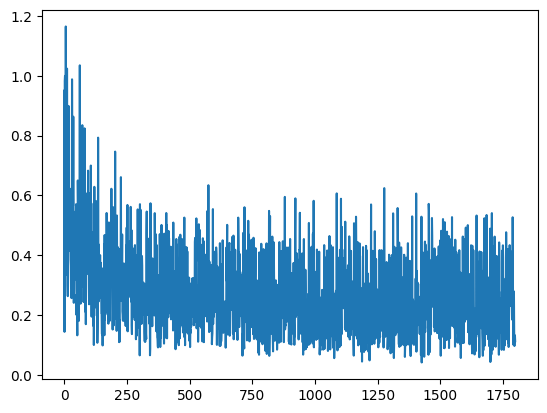

In [17]:
plt.plot(loss_values)

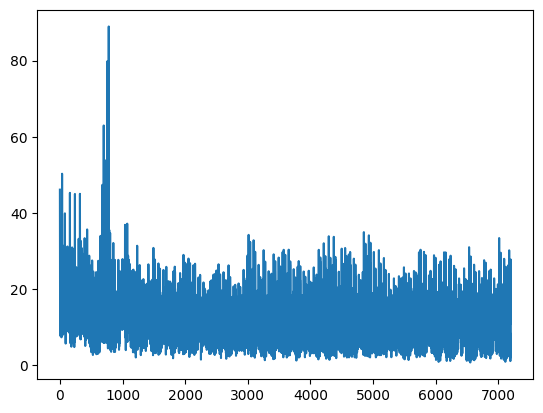

In [18]:
plt.plot(val_values_delay)

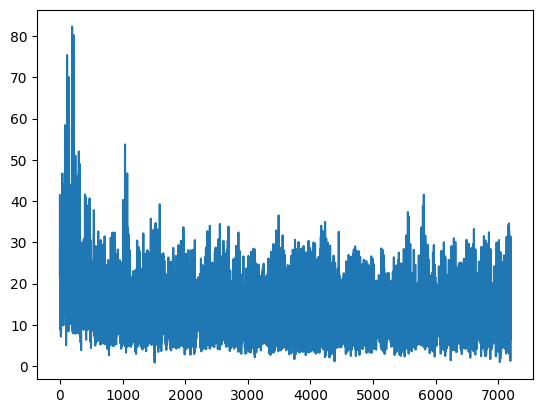

In [19]:
plt.plot(val_values_not_loss)

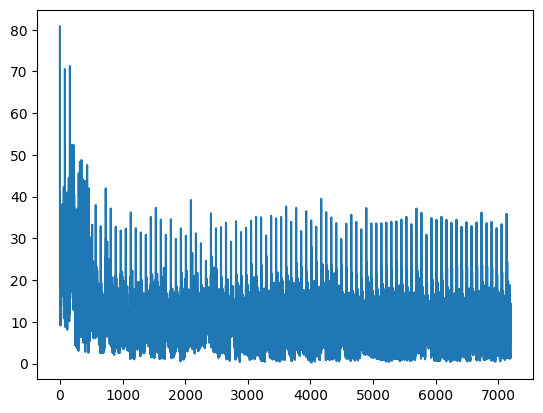

In [20]:
plt.plot(val_values_jitter)

## Load the pre-trained model

In [21]:
model.load_state_dict(torch.load(save_model_path))
model.eval()

RGCN(
  (conv1): HeteroGraphConv(
    (mods): ModuleDict(
      (traverses): GraphConv(in=4, out=20, normalization=both, activation=None)
      (composes): GraphConv(in=4, out=20, normalization=both, activation=None)
      (uses): GraphConv(in=4, out=20, normalization=both, activation=None)
      (serves): GraphConv(in=4, out=20, normalization=both, activation=None)
      (hosts): GraphConv(in=4, out=20, normalization=both, activation=None)
      (resides): GraphConv(in=4, out=20, normalization=both, activation=None)
    )
  )
  (conv2): HeteroGraphConv(
    (mods): ModuleDict(
      (traverses): GraphConv(in=20, out=3, normalization=both, activation=None)
      (composes): GraphConv(in=20, out=3, normalization=both, activation=None)
      (uses): GraphConv(in=20, out=3, normalization=both, activation=None)
      (serves): GraphConv(in=20, out=3, normalization=both, activation=None)
      (hosts): GraphConv(in=20, out=3, normalization=both, activation=None)
      (resides): GraphConv(i

## Test prediction

In [22]:
mapes_delay = []
mapes_not_loss = []
mapes_jitter = []

smapes_delay = []
smapes_not_loss = []
smapes_jitter = []

metric = MeanAbsolutePercentageError()

with torch.no_grad():
    for g in ds_test.dataset[0]:
        
        #g = transformFeatures(g)
        
        link_feats = torch.transpose(torch.stack(joinFeatures(g.nodes['link'].data)),0,1)
        path_feats = torch.transpose(torch.stack(joinFeatures(g.nodes['path'].data)),0,1)
        queue_feats = torch.transpose(torch.stack(joinFeatures(g.nodes['queue'].data)),0,1)
        labels = torch.stack((g.nodes['path'].data['delay'], g.nodes['path'].data['drops'], g.nodes['path'].data['jitter']))
        node_features = {'link': link_feats, 'path': path_feats, 'queue': queue_feats}
        logits = model(g, node_features)['path']
        logits = torch.transpose(logits,0,1)
        
        mape_delay = calculate_smape((logits[0]*(0.0230716-0.00001))+0.00001, (labels[0]*(0.0230716-0.00001))+0.00001)*100
        mapes_delay.append(mape_delay.item())

        mape_not_loss = calculate_smape(1-(logits[1]*0.741), 1-(labels[1]*0.741))*100
        mapes_not_loss.append(mape_not_loss.item())

        mape_jitter = calculate_smape((logits[2]+1)*0.000022, (labels[2]+1)*0.000022)*100
        mapes_jitter.append(mape_jitter.item())

        """smape_delay = calculate_smape(logits[0], labels[0])*100
        smapes_delay.append(smape_delay.item())

        smape_not_loss = calculate_smape(logits[1], labels[1])*100
        smapes_not_loss.append(smape_not_loss.item())

        smape_jitter = calculate_smape(logits[2], labels[2])*100
        smapes_jitter.append(smape_jitter.item())"""
        
print("SMAPE delay queue: "+str(sum(mapes_delay)/len(mapes_delay)))
print("SMAPE not loss queue: "+str(sum(mapes_not_loss)/len(mapes_not_loss)))
print("SMAPE jitter: "+str(sum(mapes_jitter)/len(mapes_jitter)))


#print("sMAPE delay queue: "+str(sum(smapes_delay)/len(smapes_delay)))
#print("sMAPE not loss queue: "+str(sum(smapes_not_loss)/len(smapes_not_loss)))
#print("sMAPE jitter: "+str(sum(smapes_jitter)/len(smapes_jitter)))

NameError: name 'ds_test' is not defined

In [ ]:
if torch.count_nonzero(logits[0]) == 0:
    print("ERROR!!")
    print((logits[0]*(0.0230716-0.00001))+0.00001)
    print((labels[0]*(0.0230716-0.00001))+0.00001)
    print(1-logits[1])
    print(1-labels[1])
    print(logits[2]*0.000022)
    print(labels[2]*0.000022)
else:
    print((logits[0]*(0.0230716-0.00001))+0.00001)
    print((labels[0]*(0.0230716-0.00001))+0.00001)
    print(1-logits[1])
    print(1-labels[1])
    print(logits[2]*0.000022)
    print(labels[2]*0.000022)